In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
from functions.dataloader import CocoDetDataset, collate_fn
ROOT = "../final_dataset"  # passe an: Basisordner, der images/ und annotations/ enthält
 
train_ds = CocoDetDataset(f"{ROOT}/annotations/instances_train.json", f"{ROOT}/images/train", resize_short=640, augment=True)
val_ds   = CocoDetDataset(f"{ROOT}/annotations/instances_val.json",   f"{ROOT}/images/val",   resize_short=640)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  num_workers=4, collate_fn=collate_fn, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)



/home/gast/Khanh/miniforge3/envs/torchvision_gpu_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gast/Khanh/miniforge3/envs/torchvision_gpu_env/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/home/gast/Khanh/Repositories/ranscht_detection/functions/transforms.py:21: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 30), p=0.3),


In [3]:
import torch
import numpy as np
from collections import defaultdict
from torchvision.ops import box_iou

def evaluate_map(model, data_loader, device, iou_thresh=0.5):
    model.eval()
    all_detections = defaultdict(list)   # class_id -> [(img_id, score, box), ...]
    all_annotations = defaultdict(list)  # class_id -> [(img_id, box), ...]
    
    img_id = 0  # globaler Bild-Index über den ganzen Loader
    
    with torch.no_grad():
        for imgs, targets in data_loader:
            # Bilder auf Device
            imgs = [im.to(device) for im in imgs]
            # Vorwärtsdurchlauf (Inference, ohne Targets!)
            outputs = model(imgs)
            
            # Für jedes Bild im Batch
            for out, tgt in zip(outputs, targets):
                # Ground Truth
                gt_boxes = tgt["boxes"].cpu()
                gt_labels = tgt["labels"].cpu()
                
                for box, label in zip(gt_boxes, gt_labels):
                    all_annotations[int(label)].append((img_id, box))
                
                # Predictions
                pred_boxes = out["boxes"].cpu()
                pred_labels = out["labels"].cpu()
                pred_scores = out["scores"].cpu()
                
                for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
                    all_detections[int(label)].append((img_id, float(score), box))
                
                img_id += 1
    
    aps = {}
    
    # AP pro Klasse berechnen
    for cls_id, detections in all_detections.items():
        gts = all_annotations[cls_id]
        if len(gts) == 0:
            # Keine GTs für diese Klasse -> überspringen
            continue
        
        # Detections nach Score sortieren (absteigend)
        detections = sorted(detections, key=lambda x: x[1], reverse=True)
        
        # Ground Truth nach Bild organisieren
        gt_by_image = defaultdict(list)
        for img_idx, box in gts:
            gt_by_image[img_idx].append({"box": box, "matched": False})
        
        tp = np.zeros(len(detections))
        fp = np.zeros(len(detections))
        n_gt = len(gts)
        
        for i, (img_idx, score, box_pred) in enumerate(detections):
            gts_img = gt_by_image[img_idx]
            if len(gts_img) == 0:
                # Kein GT in diesem Bild für diese Klasse -> FP
                fp[i] = 1
                continue
            
            gt_boxes = torch.stack([g["box"] for g in gts_img])
            ious = box_iou(box_pred.unsqueeze(0), gt_boxes)[0]
            best_iou, best_idx = ious.max(0)
            
            if best_iou >= iou_thresh and not gts_img[best_idx]["matched"]:
                tp[i] = 1
                gts_img[best_idx]["matched"] = True
            else:
                fp[i] = 1
        
        # kumulative Summen
        tp_cum = np.cumsum(tp)
        fp_cum = np.cumsum(fp)
        
        recalls = tp_cum / (n_gt + 1e-6)
        precisions = tp_cum / (tp_cum + fp_cum + 1e-6)
        
        # AP = Fläche unter der Precision-Recall-Kurve
        mrec = np.concatenate(([0.0], recalls, [1.0]))
        mpre = np.concatenate(([0.0], precisions, [0.0]))
        
        # Precision-Hülle
        for i in range(mpre.size - 1, 0, -1):
            mpre[i-1] = max(mpre[i-1], mpre[i])
        
        idxs = np.where(mrec[1:] != mrec[:-1])[0]
        ap = np.sum((mrec[idxs + 1] - mrec[idxs]) * mpre[idxs + 1])
        aps[cls_id] = ap
    
    map50 = float(np.mean(list(aps.values()))) if len(aps) > 0 else 0.0
    return map50, aps


In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2


num_classes = 2  # +1 für Hintergrund


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT").to(device)
#Entscheidet für jede Region entscheidet, welche Klasse und wo sich das Objekt befindet
in_feats = model.roi_heads.box_predictor.cls_score.in_features
# Ersetze den Kopf des Modells durch einen neuen, der die richtige Anzahl an Klassen hat
model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, 2)

model.load_state_dict(torch.load("models/model_best.pth", map_location=device))


model.to(device)

# Optional: wenn du das Modell aus Datei lädst
# model.load_state_dict(torch.load("models/model_last.pth", map_location=device))
# model.to(device)

map50, aps = evaluate_map(model, val_loader, device, iou_thresh=0.5)

print(f"mAP@0.5 (alle Klassen): {map50:.4f}")
for cls_id, ap in aps.items():
    print(f"  Klasse {cls_id}: AP@0.5 = {ap:.4f}")


mAP@0.5 (alle Klassen): 0.5783
  Klasse 1: AP@0.5 = 0.5783


mAP = mean Average Precision
@0.5 = IoU-Threshold = 0.5

Eine Prediction gilt als korrekt, wenn mind. 50 % Überlappung mit dem Ground Truth.

Aus allen Predictions wird eine Precision-Recall-Kurve berechnet → die Fläche darunter ist AP.

In [5]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def denormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406], device=t.device).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=t.device).view(3, 1, 1)
    return t * std + mean

def visualize_predictions(model, dataset, device, idxs=None, score_thresh=0.5, n=4):
    model.eval()
    
    if idxs is None:
        idxs = torch.randint(0, len(dataset), (n,)).tolist()
    else:
        idxs = list(idxs)[:n]
    
    with torch.no_grad():
        for idx in idxs:
            img, target = dataset[idx]
            img_device = img.to(device).unsqueeze(0)
            
            output = model(img_device)[0]
            pred_boxes = output["boxes"].cpu()
            pred_scores = output["scores"].cpu()
            pred_labels = output["labels"].cpu()
            
            gt_boxes = target["boxes"].cpu()
            gt_labels = target["labels"].cpu()
            
            # --------------------------
            # DENORMALISIEREN!
            # --------------------------
            img_vis = denormalize(img).cpu()
            img_vis = img_vis.permute(1, 2, 0).numpy()  # CHW → HWC
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            ax.imshow(img_vis)
            ax.set_title(f"Index {idx}")
            ax.axis("off")
            
            # Ground Truth (grün)
            for box in gt_boxes:
                x1, y1, x2, y2 = box.tolist()
                w, h = x2 - x1, y2 - y1
                ax.add_patch(patches.Rectangle(
                    (x1, y1), w, h, linewidth=1, edgecolor="lime", facecolor="none"
                ))
            
            # Predictions (rot)
            for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
                if score < score_thresh:
                    continue
                x1, y1, x2, y2 = box.tolist()
                w, h = x2 - x1, y2 - y1
                ax.add_patch(patches.Rectangle(
                    (x1, y1), w, h, linewidth=1, edgecolor="r", facecolor="none"
                ))
                ax.text(x1, y1 - 2, f"P:{int(label)} {score:.2f}", fontsize=8,
                        color="r", verticalalignment="bottom")
            
            plt.show()


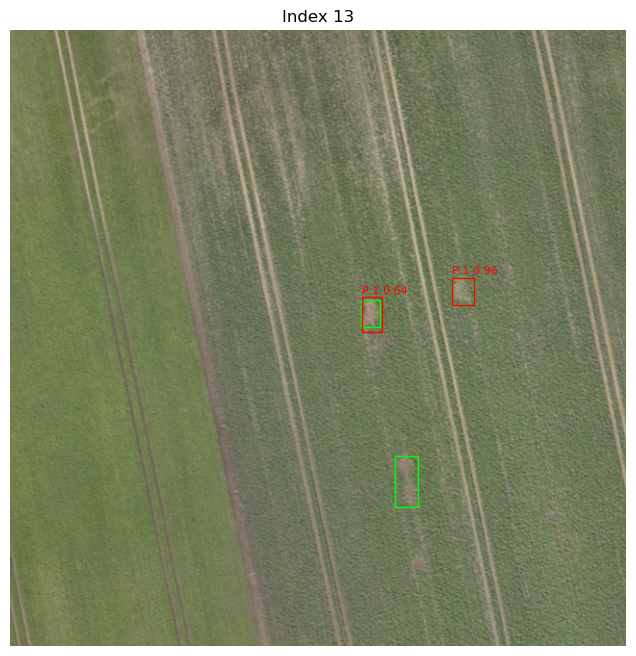

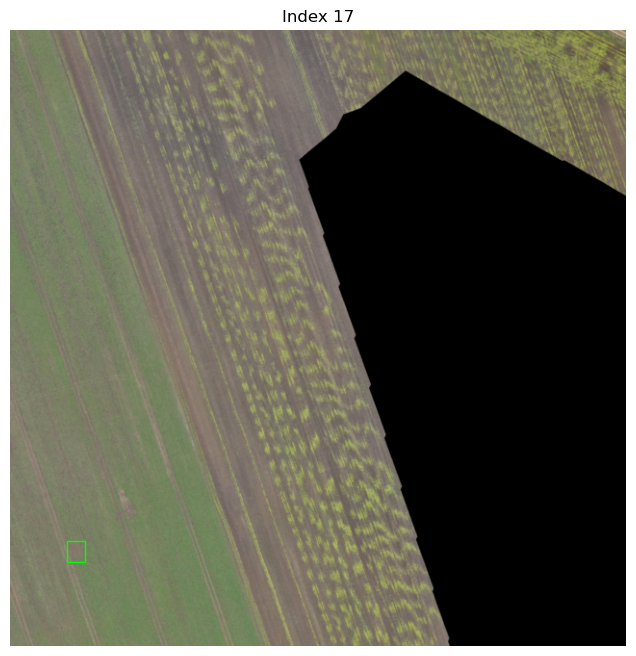

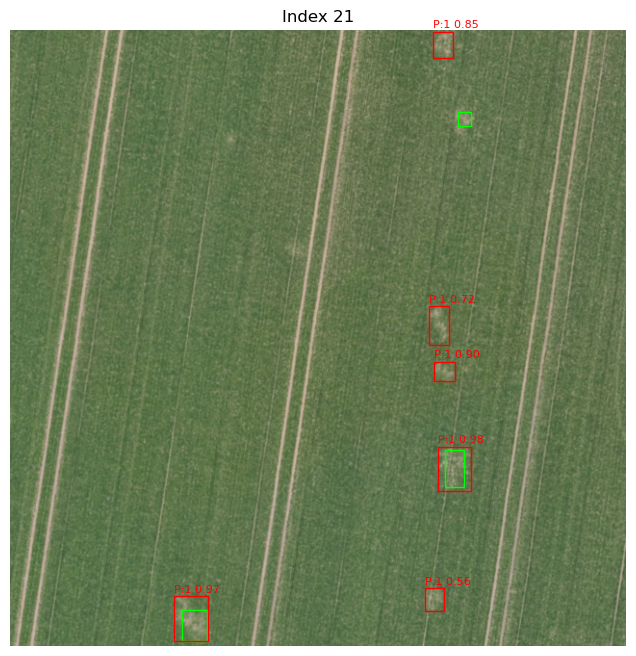

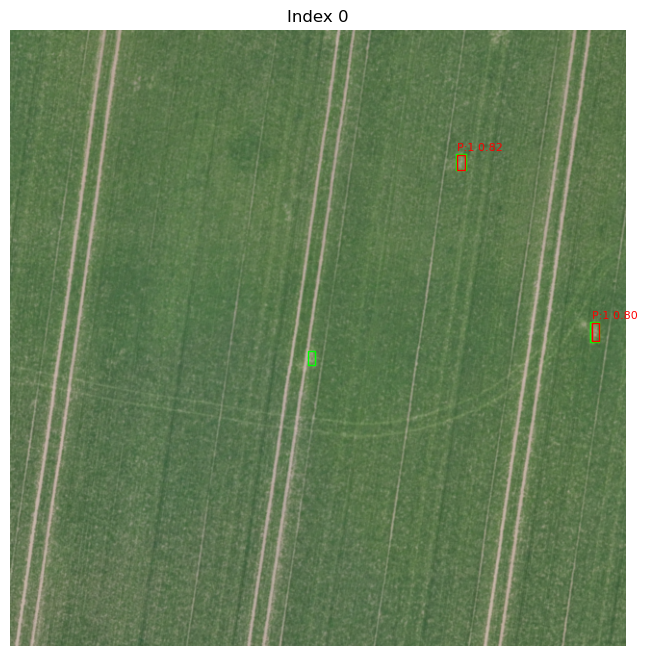

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# z.B. 4 zufällige Val-Bilder
visualize_predictions(model, val_ds, device, n=4, score_thresh=0.5)


In [7]:
import torch
import numpy as np
from collections import defaultdict
from torchvision.ops import box_iou
import matplotlib.pyplot as plt

def collect_detections_and_gts(model, data_loader, device):
    model.eval()
    all_detections = defaultdict(list)   # class_id -> [(img_id, score, box), ...]
    all_annotations = defaultdict(list)  # class_id -> [{"img_id":, "box":, "area":}, ...]

    img_id = 0

    with torch.no_grad():
        for imgs, targets in data_loader:
            imgs = [im.to(device) for im in imgs]
            outputs = model(imgs)

            for out, tgt in zip(outputs, targets):
                gt_boxes = tgt["boxes"].cpu()
                gt_labels = tgt["labels"].cpu()

                for box, label in zip(gt_boxes, gt_labels):
                    x1, y1, x2, y2 = box.tolist()
                    area = (x2 - x1) * (y2 - y1)
                    all_annotations[int(label)].append({
                        "img_id": img_id,
                        "box": box,
                        "area": area
                    })

                pred_boxes = out["boxes"].cpu()
                pred_labels = out["labels"].cpu()
                pred_scores = out["scores"].cpu()

                for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
                    all_detections[int(label)].append((img_id, float(score), box))

                img_id += 1

    return all_detections, all_annotations


In [8]:
all_dets, all_gts = collect_detections_and_gts(model, val_loader, device)


In [9]:
def compute_ap_for_class(detections, annotations, iou_thresh=0.5,
                         area_range=(0.0, 1e10)):
    """
    detections: Liste [(img_id, score, box), ...] für EINE Klasse
    annotations: Liste [{"img_id":, "box":, "area":}, ...] für EINE Klasse
    area_range: (min_area, max_area) – z.B. COCO Ranges
    """
    # Filter GT nach area_range
    filtered_anns = [a for a in annotations
                     if area_range[0] <= a["area"] < area_range[1]]

    if len(filtered_anns) == 0:
        return 0.0, None, None  # keine GT -> keine AP

    # Nach Score sortieren (absteigend)
    detections = sorted(detections, key=lambda x: x[1], reverse=True)

    # GT nach Bild gruppieren
    gt_by_img = defaultdict(list)
    for ann in filtered_anns:
        gt_by_img[ann["img_id"]].append({"box": ann["box"], "matched": False})

    tp = np.zeros(len(detections))
    fp = np.zeros(len(detections))
    n_gt = len(filtered_anns)

    for i, (img_id, score, box_pred) in enumerate(detections):
        gts_img = gt_by_img.get(img_id, [])
        if len(gts_img) == 0:
            fp[i] = 1
            continue

        gt_boxes = torch.stack([g["box"] for g in gts_img])
        ious = box_iou(box_pred.unsqueeze(0), gt_boxes)[0]
        best_iou, best_idx = ious.max(0)

        if best_iou >= iou_thresh and not gts_img[best_idx]["matched"]:
            tp[i] = 1
            gts_img[best_idx]["matched"] = True
        else:
            fp[i] = 1

    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)

    recalls = tp_cum / (n_gt + 1e-6)
    precisions = tp_cum / (tp_cum + fp_cum + 1e-6)

    # AP: Fläche unter Precision-Recall-Kurve (wie COCO, kontinuierlich)
    mrec = np.concatenate(([0.0], recalls, [1.0]))
    mpre = np.concatenate(([0.0], precisions, [0.0]))

    for i in range(mpre.size - 1, 0, -1):
        mpre[i-1] = max(mpre[i-1], mpre[i])

    idxs = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idxs + 1] - mrec[idxs]) * mpre[idxs + 1])

    return ap, recalls, precisions


In [10]:
def coco_style_eval(all_detections, all_annotations,
                    iou_thresholds=None):
    if iou_thresholds is None:
        iou_thresholds = np.arange(0.5, 0.96, 0.05)  # 0.5 ... 0.95

    area_ranges = {
        "all":   (0.0,     1e10),
        "small": (0.0,     32.0**2),
        "medium":(32.0**2, 96.0**2),
        "large": (96.0**2, 1e10)
    }

    # Ergebnisse sammeln
    ap_per_class_iou = defaultdict(dict)      # [cls][iou] = AP
    ap_per_class_size = defaultdict(dict)     # [cls][size] = AP
    pr_curves = defaultdict(dict)            # [cls][iou] = {"recalls","precisions"}

    # Alle Klassen (nur foreground, keine Hintergrund-ID)
    class_ids = sorted(all_annotations.keys())

    # 1. mAP@[0.5:0.95]
    for cls_id in class_ids:
        dets = all_detections.get(cls_id, [])
        anns = all_annotations.get(cls_id, [])

        if len(anns) == 0:
            continue

        for iou in iou_thresholds:
            ap, recalls, precisions = compute_ap_for_class(
                dets, anns, iou_thresh=iou, area_range=area_ranges["all"]
            )
            ap_per_class_iou[cls_id][float(iou)] = ap
            pr_curves[cls_id][float(iou)] = {
                "recalls": recalls,
                "precisions": precisions
            }

        # 2. AP small / medium / large
        for size_name, ar in area_ranges.items():
            ap_size, _, _ = compute_ap_for_class(
                dets, anns, iou_thresh=0.5, area_range=ar
            )
            ap_per_class_size[cls_id][size_name] = ap_size

    # mAP über Klassen und IoUs
    all_aps = []
    for cls_id in ap_per_class_iou:
        for iou, ap in ap_per_class_iou[cls_id].items():
            all_aps.append(ap)
    map_50_95 = float(np.mean(all_aps)) if all_aps else 0.0

    # mAP@0.5 separat
    all_aps_50 = []
    for cls_id in ap_per_class_iou:
        if 0.5 in ap_per_class_iou[cls_id]:
            all_aps_50.append(ap_per_class_iou[cls_id][0.5])
    map_50 = float(np.mean(all_aps_50)) if all_aps_50 else 0.0

    # 3. AP pro Klasse (z.B. bei IoU 0.5)
    ap_per_class_50 = {cls: ap_dict.get(0.5, 0.0)
                       for cls, ap_dict in ap_per_class_iou.items()}

    return {
        "map_50_95": map_50_95,
        "map_50": map_50,
        "ap_per_class_iou": ap_per_class_iou,
        "ap_per_class_50": ap_per_class_50,
        "ap_per_class_size": ap_per_class_size,
        "pr_curves": pr_curves
    }


In [11]:
all_dets, all_gts = collect_detections_and_gts(model, val_loader, device)
results = coco_style_eval(all_dets, all_gts)

print(f"mAP@[0.5:0.95]: {results['map_50_95']:.4f}")
print(f"mAP@0.5:        {results['map_50']:.4f}")

print("\nAP@0.5 pro Klasse:")
for cls_id, ap in results["ap_per_class_50"].items():
    print(f"  Klasse {cls_id}: {ap:.4f}")

print("\nAP@0.5 nach Größenklassen pro Klasse:")
for cls_id, size_dict in results["ap_per_class_size"].items():
    print(f"  Klasse {cls_id}:")
    for size_name, ap_size in size_dict.items():
        print(f"    {size_name}: {ap_size:.4f}")


mAP@[0.5:0.95]: 0.2678
mAP@0.5:        0.5783

AP@0.5 pro Klasse:
  Klasse 1: 0.5783

AP@0.5 nach Größenklassen pro Klasse:
  Klasse 1:
    all: 0.5783
    small: 0.4218
    medium: 0.4118
    large: 0.0000


- Semisupervised für mehr Annotationen
- Mehr Bilder labeln